# Chapter 6
`Original content created by Cam Davidson-Pilon`

`Ported to Python 3 and PyMC3 by Max Margenot (@clean_utensils) and Thomas Wiecki (@twiecki) at Quantopian (@quantopian)`


---

This chapter of [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) focuses on the most debated and discussed part of Bayesian methodologies: how to choose an appropriate prior distribution. We also present how the prior's influence changes as our dataset increases, and an interesting relationship between priors and penalties on linear regression.

## Getting our priorities straight
到目前为止，我们几乎忽略了对先验分布的选择。这是不幸的，因为我们可以让先验分布充满了表达能力，但我们也必须小心选择它们。尤其是，如果我们想要客观，那就不要在先验中表达任何个人倾向。

### Subjective vs Objective priors
贝叶斯先验分布可以分为两类：旨在允许数据影响后验最多的*客观先验*，以及允许从业者将其观点表达出来的*主观先验*。 

客观先验的例子是什么？我们已经看到一些已经包括flat分布的先验，这是在未知的整个可能范围内的uniform分布。使用一个flat先验意味着我们给每个可能的值相等的权重。选择这种类型的先验是为了所谓的“冷漠原则”，从字面上来说，我们没有任何理由赞成一个值超过另一个值。在被限制的空间使用flat先验作为客观先验是不正确的，尽管它似乎是相似的。比如，如果我们知道二项式模型中的$p$大于0.5，则$\text{Uniform}(0.5,1)$不是一个客观先验（因为我们已经使用了先验知识），即使它在[0.5，1]。flat prior必须在*整个*可能范围内平铺概率分布。 

除了flat prior，客观先验的其他例子不太明显，但它们包含反映客观性的重要特征。现在应该说，*很少*有客观先验是*真正*的客观，我们稍后会看到。

#### Subjective Priors
另一方面，如果我们在某个区域增加了更多的概率分布，而在另外的区域减少概率分布，那么我们就会倾向于对前一个区域存在的未知量的推断。这被称为主观的或*信息先验*。在下图中，主观先验反映了一个信念：未知可能在0.5左右，而不是极端，而客观先验对此不敏感。

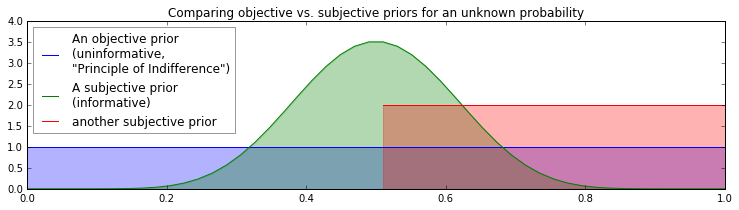

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize(12.5,3)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0,1)
y1, y2 = stats.beta.pdf(x, 1,1), stats.beta.pdf(x, 10,10)

p = plt.plot(x, y1, 
    label='An objective prior \n(uninformative, \n"Principle of Indifference")')
plt.fill_between(x, 0, y1, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x,y2 ,
     label = "A subjective prior \n(informative)")
plt.fill_between(x, 0, y2, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x[25:], 2*np.ones(25), label = "another subjective prior")
plt.fill_between(x[25:], 0, 2, color = p[0].get_color(), alpha = 0.3)

plt.ylim(0,4)

plt.ylim(0, 4)
leg = plt.legend(loc = "upper left")
leg.get_frame().set_alpha(0.4)
plt.title("Comparing objective vs. subjective priors for an unknown probability");

主观先验的选择并不总是意味着我们正在使用从业者的主观意见：更经常地，主观先验曾经是先前问题的后验，现在从业者正在用新的数据更新这个后验。主观先验也可用于将问题的*领域知识*注入模型。稍后会看到这两种情况的例子。

### Decision, decisions...
*客观*或*主观*的选择主要取决于正在解决的问题，但有一些情况会存在优先选择。在科学研究的情况下，选择客观先验是显而易见的。这消除了结果中的任何偏见，两位可能具有不同先验意见的研究人员将会觉得客观先验是公平的。考虑一个更极端的情况：

>一家烟草公司发布了一份以贝叶斯方法进行的报告，该方法回顾了60年的烟草使用医学研究。你会相信结果吗？不太可能。研究人员可能选择了一个主观的先验，过于强烈的偏见导致了他们的偏好。

不幸的是，选择一个客观先验并不选择一个flat先验那样简单，甚至今天这个问题还没有完全解决。简单地使用uniform先验也许会导致病理性问题出现。这些问题中的一些是迂腐的，但是我们将更严重的问题推迟到本章附录（TODO）。

我们必须记住，对先验分布的选择，无论是主观的还是客观的，仍然是建模过程的一部分。引用Gelman [5]： 

>...在模型拟合之后，应该看看后验分布，看看是否有意义。如果后验分布没有意义，这意味着可以使用尚未包含在模型中的额外的先验知识，并且这额外的先验知识与已经使用的先验分布是相互矛盾的。然后返回，适当的改变先验的分布，使其更符合这种外部知识。

如果后验分布没有意义，那么显然有一个想法，后验分布*应该*是什么样的（不是什么人*希望*看起来像什么），这意味着当前的先验并不包含所有先验信息，应该被更新。在这一点上，我们可以丢弃当前的先验并选择一个更具影响的。 

Gelman [4]认为，使用具有大界限的Uniform分布通常是客观先验的好选择。虽然，应该谨慎使用具有大范围的Uniform客观先验，因为它们可以将过大的先验概率分配给反直觉的点。问问自己：你真的认为未知数可能是非常大的吗？通常，量自然地偏向于0。具有较大方差（小精度）的正态随机变量可能是更好的选择，或在严格正（或负）情况下具有胖尾的指数分布。 

如果使用特定的主观先验，你有责任解释先验的选择，否则你不会比烟草公司的有罪方更好。

### Empirical Bayes
*empirical Bayes*是一个把频率和贝叶斯推理相结合的技巧，而不是一个真正的贝叶斯派方法。如前所述，对于（几乎）每个推理问题，都有一个贝叶斯方法和一个频繁的方法。两者之间的显着差异在于贝叶斯方法具有先验的分布，具有超参数$\alpha$，而经验方法没有先验的任何概念。经验贝叶斯通过使用频繁方法来选择$\alpha$，从而组合了两种方法，然后在原始问题上进行贝叶斯方法。

一个非常简单的例子如下：假设我们希望估计一个正态分布的参数$\mu$，$\alpha=5$已知。由于$\mu$可以在整个实线范围内，所以我们可以使用正态分布作为$\mu$的先验。如何选择先验的超参数，表示为$(\mu_p, \alpha^2_p)$？参数$\alpha^2_p$可以用来反映我们的不确定性。对于$\mu_p$，我们有两个选择：

1. 经验贝叶斯建议使用观察的样本均值，这将围绕观察到的经验平均值居中：

$$ \mu_p = \frac{1}{N} \sum_{i=0}^N X_i $$

2. 传统的贝叶斯推理建议使用先验知识，或更客观的先验（零均值和flat标准偏差）。

经验贝叶斯可以被认为是半客观的，因为虽然先验模型的选择是我们决定的（因此是主观的），但这些参数仅由数据决定。

就个人而言，我觉得经验贝叶斯是对数据进行*双重计数*。也就是说，我们使用了两次数据：一次在先验，这将影响我们对观察数据的结果，再次在MCMC的推理过程中。这种双重计数将低估我们对真实的不确定性。为了最小化这种重复计数，我只会建议在有*很多*观测数据时才使用经验贝叶斯，否则先验的影响力将会太大。如果可能，我也建议保持高度的不确定性（通过设置大的$\alpha^2_p$或等同物）。

经验贝叶斯也违反了贝叶斯推理的理论公理。贝叶斯教科书：

>*prior* $\Rightarrow$ *observed data* $\Rightarrow$ *posterior* 

被经验贝叶斯所违反，被替换为：

>*observed data* $\Rightarrow$ *prior* $\Rightarrow$ *observed data* $\Rightarrow$ *posterior*

理想情况下，在我们观察数据之前，应先指定所有先验分布，以便数据不影响我们的先验观点（参见Daniel Kahneman等人关于 [anchoring](http://en.wikipedia.org/wiki/Anchoring_and_adjustment)的研究）。

## Useful priors to know about

### The Gamma distribution

A Gamma random variable, denoted $X \sim \text{Gamma}(\alpha, \beta)$, 是一个在正实数域的随机变量. 它实际上是指数随机变量的泛化, that is:

$$ \text{Exp}(\beta) \sim \text{Gamma}(1, \beta) $$

附加的参数允许概率密度函数具有更多的灵活性，因此允许从业者更准确地表达他或她的主观先验。$\text{Gamma}(\alpha, \beta)$随机变量的概率密度函数为：

$$ f(x \mid \alpha, \beta) = \frac{\beta^{\alpha}x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)} $$

where $\Gamma(\alpha)$ is the [Gamma function](http://en.wikipedia.org/wiki/Gamma_function), and for differing values of $(\alpha, \beta)$ looks like:

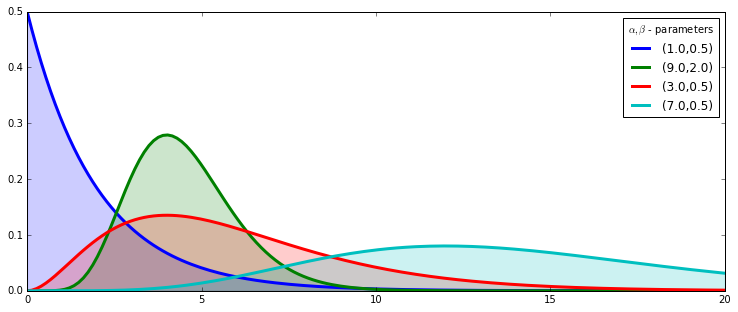

In [2]:
figsize(12.5, 5)
gamma = stats.gamma

parameters = [(1, 0.5), (9, 2), (3, 0.5), (7, 0.5)]
x = np.linspace(0.001 ,20, 150)
for alpha, beta in parameters:
    y = gamma.pdf(x, alpha, scale=1./beta)
    lines = plt.plot(x, y, label = "(%.1f,%.1f)"%(alpha,beta), lw = 3)
    plt.fill_between(x, 0, y, alpha = 0.2, color = lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.legend(title=r"$\alpha, \beta$ - parameters");

### The Wishart distribution
直到现在，我们只看到随机变量是标量。当然，我们也可以是*随机矩阵*！具体来说，Wishart分布是所有正半定矩阵的分布 [positive semi-definite matrices](http://en.wikipedia.org/wiki/Positive-definite_matrix)。为什么在我们的武器库中有用？（合法的）协方差矩阵是半正定的，因此，Wishart是协方差矩阵的一个近似先验。我们不能真正地看到矩阵的分布，所以我将从$5 \times 5$上）和$20 \times 20$（下）的Wishart分布中绘制一些可视化效果：

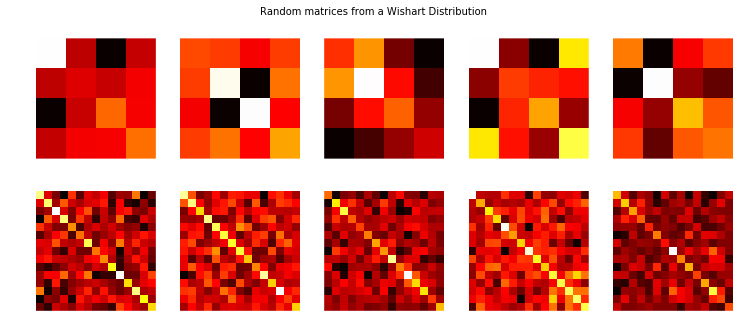

In [3]:
n = 4
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    if i >= 5:
        n = 15
    plt.imshow(stats.wishart.rvs(n+1, np.eye(n)), interpolation="none", 
                cmap = "hot")
    ax.axis("off")
    
plt.suptitle("Random matrices from a Wishart Distribution");

需要注意的是这些矩阵的对称性。 Wishart分布处理起来可以有点麻烦，但我们稍后会在一个例子中使用它。

### The Beta distribution

You may have seen the term `beta` in previous code in this book. Often, I was implementing a Beta distribution. The Beta distribution is very useful in Bayesian statistics. A random variable $X$ has a $\text{Beta}$ distribution, with parameters $(\alpha, \beta)$, if its density function is:

$$f_X(x | \; \alpha, \beta ) = \frac{ x^{(\alpha - 1)}(1-x)^{ (\beta - 1) } }{B(\alpha, \beta) }$$

where $B$ is the [Beta function](http://en.wikipedia.org/wiki/Beta_function) (hence the name). The random variable $X$ is only allowed in [0,1], making the Beta distribution a popular distribution for decimal values, probabilities and proportions. The values of $\alpha$ and $\beta$, both positive values, provide great flexibility in the shape of the distribution. Below we plot some distributions:

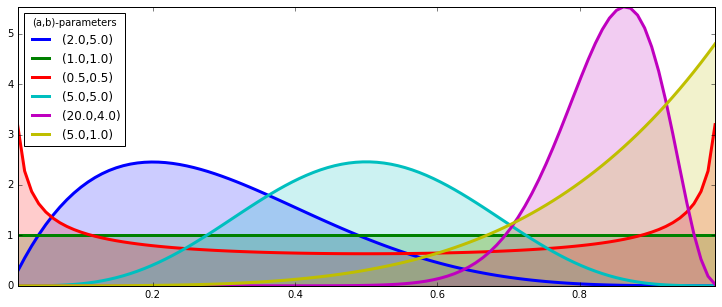

In [4]:
figsize(12.5, 5)

params = [(2, 5), (1, 1), (0.5, 0.5), (5, 5), (20, 4), (5, 1)]

x = np.linspace(0.01, .99, 100)
beta = stats.beta
for a, b in params:
    y = beta.pdf(x, a, b)
    lines = plt.plot(x, y, label = "(%.1f,%.1f)"%(a,b), lw = 3)
    plt.fill_between(x, 0, y, alpha = 0.2, color = lines[0].get_color())
    plt.autoscale(tight=True)
plt.ylim(0)
plt.legend(loc = 'upper left', title="(a,b)-parameters");

我想让读者注意到由参数$(1,1）$指定的上面的flat分布的存在，这是uniform分布。因此，Beta分布是Uniform分布的泛化，我们将再次多次看到。

Beta分布和二项式分布之间有一个有趣的联系。假设我们对一些未知的比例或概率$p$感兴趣。我们给$p$分配一个$\text{Beta}(\alpha, \beta)$先验。我们观察到一些数据可以由Binomial过程生成，例如$p$仍然未知的情况下，说$X \sim \text{Binomial}(N, p)$。那么我们的后验分布还是一个*Beta*分布，即$p | X \sim \text{Beta}( \alpha + X, \beta + N -X )$。简而言之，人们可以通过“Binomial观测值在一个Beta先验的情况下生成一个Beta后验分布”来将两者联系起来。这是一个非常有用的属性，无论从计算角度还是启发式角度。

鉴于上述的两段话，如果我们对$p$（Uniform）从一个$\text{Beta}(1,1)$先验开始，观测到数据$X \sim \text{Binomial}(N, p)$，那么我们的后验分布为$\text{Beta}(1 + X, 1 + N - X)$。

##### Example: Bayesian Multi-Armed Bandits
*Adapted from an example by Ted Dunning of MapR Technologies*

> 假设你面前有$N$台老虎机（五颜六色的那个叫做多武装土匪）。每个老虎机都有一个关于奖品分布的未知概率（假设每个老虎机的奖品是一样的，只是概率分布不同）。一些老虎机很慷慨，另一些则不是。当然，你不知道这些概率是多少。通过每轮选择一个老虎机，我们的任务是设计一个策略来最大化我们的收益。

当然，如果我们知道每个老虎机的最大概率，那么总是选择使用那个老虎机会产生最大的收益。所以我们的任务可以被解释为“以最快的速度，找到最好的老虎机”。

这个任务因为老虎机的随机性而变得很复杂，一个次优的老虎机也可以返回许多收益，纯粹是偶然的，让我们觉得那个老虎机就是最好的那个。相似的，最好的可以返回许多收益。我们应该继续尝试其他的，还是放弃？

一个棘手的问题是，如果我们发现一个老虎机能给*相当好*的收益，为了维护我们*相当好*的分数而继续从这个老虎机取，还是尝试其他的老虎机，从而希望找到一个更好的老虎机？这是探索与开采的两难选择。


### Applications
The Multi-Armed Bandit问题期初看起来像是人为的问题，只有一些数学家才会喜欢思考，但是这个看法只在我们碰到一些真实的应用前才成立：
- 互联网展示广告：公司有一套潜在的广告，他们可以向访问者展示，但该公司不确定哪个广告策略遵从最大的销售额。这与A/B测试类似，但是有一些自然最小化策略不起作用的附加优势（并将其推广到A / B / C / D ...策略）的附加优势，
- 生态学：动物只有一定的能量消耗，一些确定的行为有不确定的回报。动物如何最大化其收益？
- 财务：根据时间变化的回报资料，哪个股票期权给出最高的回报。
- 临床试验：研究人员希望在尽可能多的治疗中找到最佳治疗方法，同时尽量减少损失。
- 心理学：惩罚和报酬如何影响我们的行为？人类如何学习？


上述许多问题是应用领域的基础问题。 

事实证明，*最佳解决方案*难以置信，需要几十年的时间来开发。还有许多近似优化的解决方案是非常好的。我想讨论的是一个可以很好地扩展的少数几个解决方案之一，该解决方案被称为*Bayesian Bandists*。


### A Proposed Solution
任何提出的策略被称为*在线算法*（不是在互联网意义上，而是在不断更新的意义上），更具体地说是强化学习算法。该算法从无知状态开始，在该状态中，它不知道任何事情，然后通过开始获取数据来测试系统。当它获取数据和返回结果时，它会了解最好的和最差的行为（在这种情况下，它会学习哪个老虎机是最好的）。考虑到这一点，也许我们可以添加一个额外的应用到多老虎机问题上：

贝叶斯解决方案首先假定在先验分布上，每个老虎机获胜的概率。在我们的小插曲中，我们完全无视这些概率。所以一个非常自然的先验分布是flat先验，范围从[0, 1]。算法进行如下：

对每一轮：
1. Sample a random variable $X_b$ from the prior of bandit $b$, for all $b$.
2. Select the bandit with largest sample, i.e. select $B = \text{argmax}\;\; X_b$.
3. Observe the result of pulling bandit $B$, and update your prior on bandit $B$.
4. Return to 1.

就是这样而已，在计算上，该算法涉及从$N$个分布中采样。因为初始的先验是$\text{Beta}(\alpha=1,\beta=1)$ (a uniform distribution)，并且观察到的结果$X$（赢或输，各自编码为1和0）是Binomial，那么后验分布是一个$\text{Beta}(\alpha=1+X,\beta=1+1−X)$。

为了回答我们之前提出的问题，这个算法建议我们不应该丢弃当前非最优的，而是通过减慢对它们的尝试频率以便收集更多关于确实还有*更好*的老虎机存在的信心。这是因为被剔除的老虎机总是有达到非零状态的机会，但是当我们进行更多回合时，这个事件的概率会明显减少。

下面我们用两个类来实现Bayesian Bandists，`Bandists`定义了每个老虎机对象，`BayesianStrategy`实现了上述的学习策略。

In [5]:
rand = np.random.rand

class Bandits(object):
    """
    This class represents N bandits machines.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        pull( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
        
    def pull(self, i):
        #i is which arm to pull
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)

    
class BayesianStrategy(object):
    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
    
    methods:
        sample_bandits(n): sample and train on n pulls.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """
    
    def __init__(self, bandits):
        
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    
    def sample_bandits(self, n=1):
        
        bb_score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):
            #sample from the bandits's priors, and select the largest sample
            choice = np.argmax(np.random.beta(1 + self.wins, 1 + self.trials - self.wins))
            
            #sample the chosen bandit
            result = self.bandits.pull(choice)
            
            #update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result 
            self.N += 1
            choices[k] = choice
            
        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return 

下面我们可视化贝叶斯老虎机解决方案的学习过程。

In [6]:
figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001,.999,200)

def plot_priors(bayesian_strategy, prob, lw = 3, alpha = 0.2, plt_vlines = True):
    ## plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1+wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw = lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x,y.pdf(x),0, color = c, alpha = alpha, 
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]) ,
                       colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +\
                    "s"*(bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

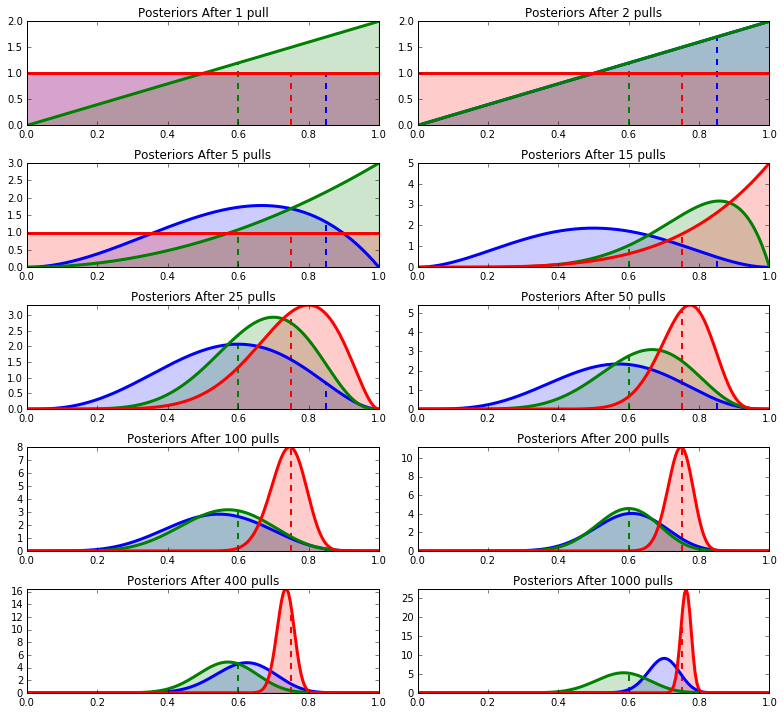

In [7]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j,i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    #plt.legend()
    plt.autoscale(tight = True)
plt.tight_layout()

请注意，我们不太在意我们对隐藏概率的推断有多准确——对于这个问题，我们更有兴趣选择最好的老虎机（或更准确地说，选择最好的老虎机更有信心）。因此，红色老虎机的分布非常广泛（表示对其隐藏概率可能是无知的），但是我们有理由相信它不是最好的，所以算法选择忽略它。

从上面可以看出，经过1000次拉杆，大部分“蓝色”的拉杆引导了the pack，所以我们几乎总是选择这个拉个。这是好的，因为这个拉杆确实是最好的。 

下面是一个D3应用程序，演示了我们的算法更新/学习三个拉杆。第一个数字是拉和胜的原始计数，第二个数字是动态更新图。我鼓励你通过选择`arm buttons`来尝试猜测哪个拉杆是最好的，这是对真实概率的先验。

In [8]:
from IPython.core.display import HTML

#try executing the below command twice if the first time doesn't work
HTML(filename = "BanditsD3.html")

从最高概率观察到的比率的偏差是拉杆性能的度量。例如，从长远来看，我们可以最大限度地从最好的bandit获得最大概率的奖励/拉动比。长期实现的比例小于最大值表现出低效率。（认识到大于最大概率的比率纯粹是由随机性导致的，并且最终其比率将下落到最大概率以下）。


### A Measure of *Good*

我们需要一个度量来计算我们做的如何。回忆绝对*最好*只有当我们总是以赢的最大的概率选择bandit，用$w_opt$代表最好的bandit的概率。我们分数应该是由从开始到目前，我们的选择使得我们之前做的如何的好确定的。这样就激励了叫做总的遗憾的策略，定义为：

\begin{align}
R_T & = \sum_{i=1}^{T} \left( w_{opt} - w_{B(i)} \right)\\\\
& = Tw^* - \sum_{i=1}^{T} \;  w_{B(i)} 
\end{align}

其中$w_{B(i)}$是在第$i$轮中，选择bandit所获得奖品的概率。总的遗憾为0意味着这个策略与可能的最棒的得分匹配。这似乎不太可能，因为在我们算法的初始阶段，会经常做出错误的选择。理想情况下，一个策略的总遗憾数应该随着它学到最好的bandit而变得平坦。（数学上，我们经常达到$w_{B(i)}=w_{opt}$ ）

下面我们画出总遗憾的模拟图，包括一些其他策略的得分：
1. Random: randomly choose a bandit to pull. If you can't beat this, just stop. 
2. Largest Bayesian credible bound: pick the bandit with the largest upper bound in its 95% credible region of the underlying probability. 
3. Bayes-UCB algorithm: pick the bandit with the largest *score*, where score is a dynamic quantile of the posterior (see [4] )
3. Mean of posterior: choose the bandit with the largest posterior mean. This is what a human player (sans computer) would likely do. 
3. Largest proportion: pick the bandit with the current largest observed proportion of winning. 

这些代码放在`other_strats.py`，你可以非常容易的自己实现。

In [9]:
figsize(12.5, 5)
from other_strats import *

#define a harder problem
hidden_prob = np.array([0.15, 0.2, 0.1, 0.05])
bandits = Bandits(hidden_prob)

#define regret
def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

#create new strategies
strategies= [upper_credible_choice, 
            bayesian_bandit_choice, 
            ucb_bayes , 
            max_mean,
            random_choice]
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))

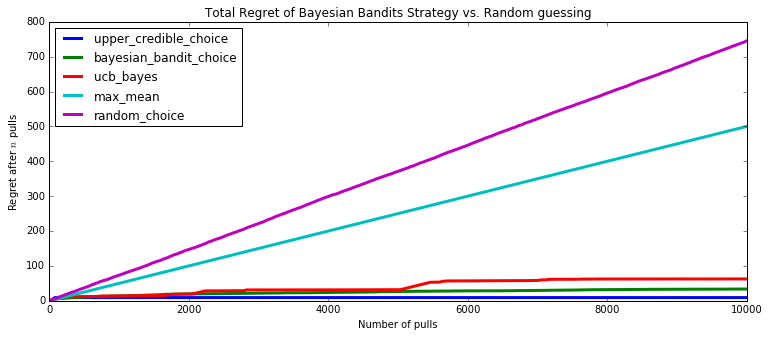

In [10]:
#train 10000 times
for strat in algos:
    strat.sample_bandits(10000)
    
#test and plot
for i,strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices)
    plt.plot(_regret, label = strategies[i].__name__, lw = 3)

plt.title("Total Regret of Bayesian Bandits Strategy vs. Random guessing")
plt.xlabel("Number of pulls")
plt.ylabel("Regret after $n$ pulls");
plt.legend(loc = "upper left");

正如我们想要的那样，贝叶斯bandits和其他策略都减少了遗憾的发生率，这说明我们达成了最优的选择。为了科学地移除上述模拟中的任何可能的运气成分，我们应该看看*期望的总遗憾*：

$$\bar{R}_T = E[ R_T ] $$

可以看出，任何次优策略的期望总后悔都在对数以下。从形式上有：

$$ E[R_T] = \Omega \left( \;\log(T)\; \right) $$

因此，任何满足遗憾对数增长的策略都可以被认为“解决”了 Multi-Armed Bandit problem [3].

使用大数法则，我们可以通过执行相同的实验许多次（500次大概就可以）来使贝叶斯bandit的逼近其期望总遗憾：

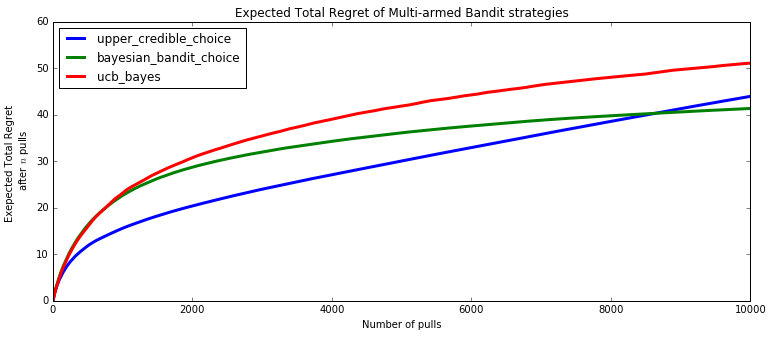

In [11]:
#this can be slow, so I recommend NOT running it. 

trials = 500
expected_total_regret = np.zeros((10000, 3))

for i_strat, strat in enumerate(strategies[:-2]):
    for i in range(trials):
        general_strat = GeneralBanditStrat(bandits, strat)
        general_strat.sample_bandits(10000)
        _regret =  regret(hidden_prob, general_strat.choices)
        expected_total_regret[:,i_strat] += _regret
    plt.plot(expected_total_regret[:,i_strat]/trials, lw =3, label = strat.__name__)
        
plt.title("Expected Total Regret of Multi-armed Bandit strategies")
plt.xlabel("Number of pulls")
plt.ylabel("Exepected Total Regret \n after $n$ pulls");
plt.legend(loc = "upper left");

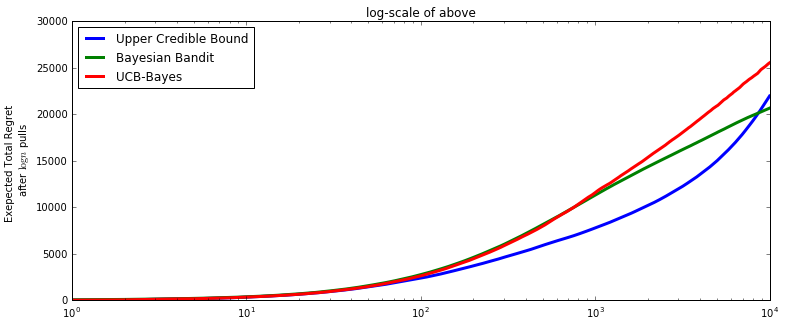

In [12]:
plt.figure()
[pl1, pl2, pl3] = plt.plot(expected_total_regret[:, [0,1,2]], lw = 3)
plt.xscale("log")
plt.legend([pl1, pl2, pl3], 
           ["Upper Credible Bound", "Bayesian Bandit", "UCB-Bayes"],
            loc="upper left")
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");
plt.title( "log-scale of above" );
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");

### Extending the algorithm 

因为贝叶斯bandit算法的简单性，它很容易扩展。一些可能的地方：
- 如果对*minimum*概率感兴趣（eg：哪个的奖品是不好的），简单地选择$B = \text{argmin} \; X_b$然后执行。

- 增加学习速率：假设潜在的环境可能随着时间的推移而改变。技术上，通过注意到它认为最好的开始点更频繁地失败，标准的贝叶斯bandit算法会自动更新自己（酷炫）。我们可以通过在更新时添加*速率项*来激励算法更快地学习变化的环境：

        self.wins[choice] = rate*self.wins[choice] + result
        self.trials[choice] = rate*self.trials[choice] + 1
    如果`rate < 1`，该算法将会更快地*忘记*其先前的胜利，并且将会对无知产生向下的压力。反过来，设置`rate > 1`，意味着你的算法将会采取更有风险的行为，并且更多地打赌较早的获胜者，并且能够更好地抵御不断变化的环境。
    
- 分层算法：我们可以在较小的bandit算法之上设置贝叶斯bandit算法。假设我们有$N$个贝叶斯bandit模型，每个都有一些行为变化（例如，不同的`rate`参数，表示对不断变化的环境的敏感性变化）。在这些$N$模型之上，另一个贝叶斯bandit学习者，它将选择一个下面的贝叶斯bandit。这个选择的贝叶斯bandit将会对哪个机器进行pull做出内部选择。顶层的贝叶斯bandit更新自己取决于下面的贝叶斯bandit是否正确。

- Extending the rewards, denoted $y_a$ for bandit $a$, to random variables from a distribution $f_{y_a}(y)$ is straightforward. More generally, this problem can be rephrased as "Find the bandit with the largest expected value", as playing the bandit with the largest expected value is optimal. In the case above, $f_{y_a}$ was Bernoulli with probability $p_a$, hence the expected value for a bandit is equal to $p_a$, which is why it looks like we are aiming to maximize the probability of winning. If $f$ is not Bernoulli, and it is non-negative, which can be accomplished apriori by shifting the distribution (we assume we know $f$), then the algorithm behaves as before:

   For each round, 
    
   1. Sample a random variable $X_b$ from the prior of bandit $b$, for all $b$.
   2. Select the bandit with largest sample, i.e. select bandit $B = \text{argmax}\;\; X_b$.
   3. Observe the result,$R \sim f_{y_a}$, of pulling bandit $B$, and update your prior on bandit $B$.
   4. Return to 1

   The issue is in the sampling of $X_b$ drawing phase. With Beta priors and Bernoulli observations, we have a Beta posterior &mdash; this is easy to sample from. But now, with arbitrary distributions $f$, we have a non-trivial posterior. Sampling from these can be difficult.

- There has been some interest in extending the Bayesian Bandit algorithm to commenting systems. Recall in Chapter 4, we developed a ranking algorithm based on the Bayesian lower-bound of the proportion of upvotes to total votes. One problem with this approach is that it will bias the top rankings towards older comments, since older comments naturally have more votes (and hence the lower-bound is tighter to the true proportion). This creates a positive feedback cycle where older comments gain more votes, hence are displayed more often, hence gain more votes, etc. This pushes any new, potentially better comments, towards the bottom. J. Neufeld proposes a system to remedy this that uses a Bayesian Bandit solution.

他建议将每个comment视为一个bandit，其pull的次数对应其获得的总票数，然后获得的奖品对应于总的赞成票数，因此可以创建一个$\text{Beta}(1+U,1+D)$后验分布。一个访问者阅读网页，从每个bandit/comment获取样本，而不是使用展示有$max$样本的comment，这些comments根据它们各自的样本数进行排名。From J. Neufeld's blog [7]:
   > [The] resulting ranking algorithm is quite straightforward, each new time the comments page is loaded, the score for each comment is sampled from a $\text{Beta}(1+U,1+D)$, comments are then ranked by this score in descending order... This randomization has a unique benefit in that even untouched comments $(U=1,D=0)$ have some chance of being seen even in threads with 5000+ comments (something that is not happening now), but, at the same time, the user is not likely to be inundated with rating these new comments. 

只是为了好玩，虽然颜色爆炸，我们看到贝叶斯强盗算法学习了15个不同的选择。

[ 0.00434787  0.06360885  0.1125568   0.17740869  0.02912234  0.07263435
  0.07908176  0.0803276   0.00486625  0.00164607  0.06442395  0.18143868
  0.08838014  0.0268295   0.03849572  0.01100816  0.05687894  0.00478555
  0.08837475  0.08064843  0.18513188  0.11545282  0.00107493  0.04723821
  0.1066852   0.05270096  0.00605835  0.06243076  0.01901726  0.37930393
  0.0377272   0.00256024  0.16159018  0.04575739  0.10374259]


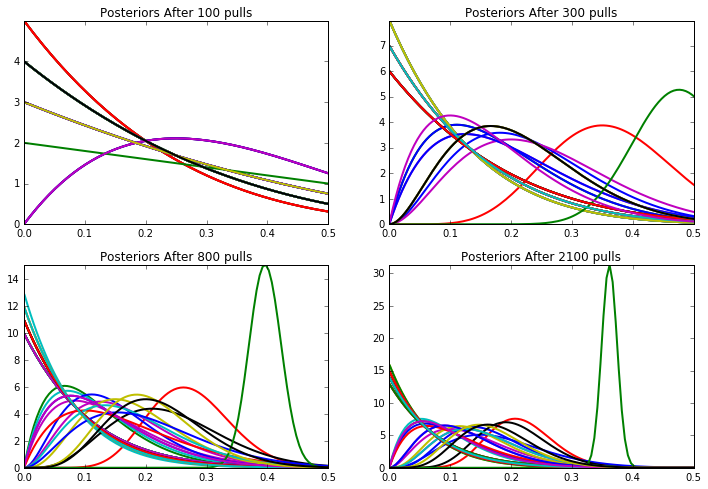

In [13]:
figsize(12.0, 8)
beta = stats.beta
hidden_prob = beta.rvs(1,13, size = 35)
print(hidden_prob)
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

for j,i in enumerate([100, 200, 500, 1300]):
    plt.subplot(2, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob, lw = 2, alpha = 0.0, plt_vlines=False)
    #plt.legend()
    plt.xlim(0, 0.5)


## Eliciting expert prior

Specifying a subjective prior is how practitioners incorporate domain knowledge about the problem into our mathematical framework. Allowing domain knowledge is useful for many reasons:

- Aids speeds of MCMC convergence. For example, if we know the unknown parameter is strictly positive, then we can restrict our attention there, hence saving time that would otherwise be spent exploring negative values.
- More accurate inference. By weighing prior values near the true unknown value higher, we are narrowing our eventual inference (by making the posterior tighter around the unknown) 
- Express our uncertainty better. See the *Price is Right* problem in Chapter 5.

plus many other reasons. Of course, practitioners of Bayesian methods are not experts in every field, so we must turn to domain experts to craft our priors. We must be careful with how we elicit these priors though. Some things to consider:

1. From experience, I would avoid introducing Betas, Gammas, etc. to non-Bayesian practitioners. Furthermore, non-statisticians can get tripped up by how a continuous probability function can have a value exceeding one.

2. Individuals often neglect the rare *tail-events* and put too much weight around the mean of distribution. 

3. Related to above is that almost always individuals will under-emphasize the uncertainty in their guesses.

Eliciting priors from non-technical experts is especially difficult. Rather than introduce the notion of probability distributions, priors, etc. that may scare an expert, there is a much simpler solution. 

### Trial roulette method 


The *trial roulette method* [8] focuses on building a prior distribution by placing counters (think casino chips) on what the expert thinks are possible outcomes. The expert is given $N$ counters (say $N=20$) and is asked to place them on a pre-printed grid, with bins representing intervals.  Each column would represent their belief of the probability of getting the corresponding bin result. Each chip would represent an $\frac{1}{N} = 0.05$ increase in the probability of the outcome being in that interval. For example [9]:

> A student is asked to predict the mark in a future exam. The figure below shows a completed grid for the elicitation of a subjective probability distribution. The horizontal axis of the grid shows the possible bins (or mark intervals) that the student was asked to consider. The numbers in top row record the number of chips per bin. The completed grid (using a total of 20 chips) shows that the student believes there is a 30% chance that the mark will be between 60 and 64.9.


<img style="margin: auto" src="http://img641.imageshack.us/img641/4716/chipsbinscrisp.png" />

From this, we can fit a distribution that captures the expert's choice. Some reasons in favor of using this technique are:

1. Many questions about the shape of the expert's subjective probability distribution can be answered without the need to pose a long series of questions to the expert - the statistician can simply read off density above or below any given point, or that between any two points.

2. During the elicitation process, the experts can move around the chips if unsatisfied with the way they placed them initially - thus they can be sure of the final result to be submitted.

3. It forces the expert to be coherent in the set of probabilities that are provided. If all the chips are used, the probabilities must sum to one.

4. Graphical methods seem to provide more accurate results, especially for participants with modest levels of statistical sophistication.

##### Example: Stock Returns


Take note stock brokers: you're doing it wrong. When choosing which stocks to pick, an analyst will often look at the *daily return* of the stock. Suppose $S_t$ is the price of the stock on day $t$, then the daily return on day $t$ is :

$$r_t = \frac{ S_t - S_{t-1} }{ S_{t-1} } $$

The *expected daily return* of a stock is denoted $\mu = E[ r_t ]$. Obviously, stocks with high expected returns are desirable. Unfortunately, stock returns are so filled with noise that it is very hard to estimate this parameter. Furthermore, the parameter might change over time (consider the rises and falls of AAPL stock), hence it is unwise to use a large historical dataset. 

Historically, the expected return has been estimated by using the sample mean. This is a bad idea. As mentioned, the sample mean of a small sized dataset has enormous potential to be very wrong (again, see Chapter 4 for full details). Thus Bayesian inference is the correct procedure here, since we are able to see our uncertainty along with probable values.

For this exercise, we will be examining the daily returns of the AAPL, GOOG, MSFT and AMZN. Before we pull in the data, suppose we ask our a stock fund manager (an expert in finance, but see [10] ), 

> What do you think the return profile looks like for each of these companies?

Our stock broker, without needing to know the language of Normal distributions, or priors, or variances, etc. creates four distributions using the trial roulette method above. Suppose they look enough like Normals, so we fit Normals to them. They may look like: 

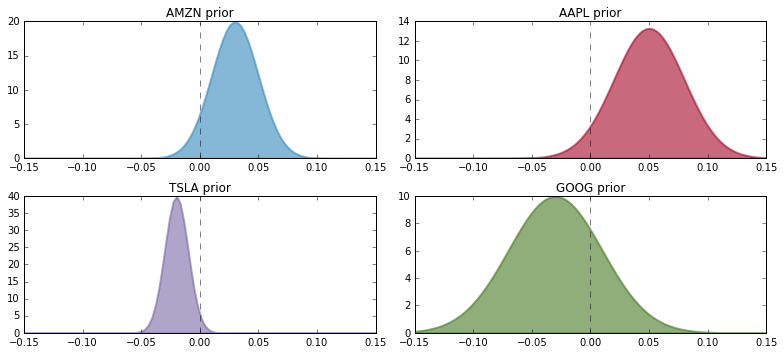

In [14]:
figsize(11., 5)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

normal = stats.norm
x = np.linspace(-0.15, 0.15, 100)

expert_prior_params = {"AAPL":(0.05, 0.03),
                 "GOOG":(-0.03, 0.04), 
                 "TSLA": (-0.02, 0.01), 
                 "AMZN": (0.03, 0.02), 
                 }

for i, (name, params) in enumerate(expert_prior_params.items()):
    plt.subplot(2, 2, i+1)
    y = normal.pdf(x, params[0], scale = params[1])
    #plt.plot( x, y, c = colors[i] )
    plt.fill_between(x, 0, y, color = colors[i], linewidth=2,
                     edgecolor = colors[i], alpha = 0.6)
    plt.title(name + " prior")
    plt.vlines(0, 0, y.max(), "k","--", linewidth = 0.5)
    plt.xlim(-0.15, 0.15)
plt.tight_layout()

注意到这些都是主观先验：对这些公司的股票收益，专家都有个人意见，并且将其表现到一个分布中。他不是一厢情愿——他正在引入领域知识。

为了更好地模拟这些回报收益，我们应该研究下回报的*协方差矩阵*。例如，投资两个高度相关的股票是不明智的，因为它们有可能汇集在一起（这就是为什么基金经理建议多元化投资策略）。我们将之前介绍的Wishart分布使用进来。

让我们得到这些股票的一些历史数据。我们将使用回报的协方差作为我们的Wishart随机变量的起点。这不是经验性的贝叶斯（我们将在后面讨论），因为我们只是决定起点，而不是影响参数。

In [ ]:
# I wish I could have used Pandas as a prereq for this book, but oh well.
import datetime
import collections
import ystockquote as ysq
import pandas as pd

n_observations = 100 # we will truncate the the most recent 100 days.

stocks = ["AAPL", "GOOG", "TSLA", "AMZN"]

enddate = "2015-04-27"
startdate = "2012-09-01"

CLOSE = 6

stock_closes = pd.DataFrame()

for stock in stocks:
    x = np.array(ysq.get_historical_prices(stock, startdate, enddate))
    stock_series = pd.Series(x[1:,].astype(float), name=stock)
    stock_closes[stock] = stock_series

stock_closes = stock_closes[::-1]
stock_returns = stock_closes.pct_change()[1:][-n_observations:]
    
dates = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), x[1:n_observations+1,0]))

这里我们构建基本模型：

In [ ]:
import pymc3 as pm
import theano.tensor as tt
from theano.tensor.nlinalg import matrix_inverse, diag, matrix_dot

prior_mu = np.array([x[0] for x in expert_prior_params.values()])
prior_std = np.array([x[1] for x in expert_prior_params.values()])

init = stock_returns.cov()

with pm.Model() as model:
    cov_matrix = pm.WishartBartlett("covariance", np.diag(prior_std**2), 10, testval = init)

    mu = pm.Normal("returns", mu=prior_mu, sd=1, shape=4)

这里使我们选择的股票的回报收益：

In [ ]:
figsize(12.5, 4)

cum_returns = np.cumprod(1 + stock_returns) - 1
cum_returns.index = dates[::-1]
cum_returns.plot()

plt.legend(loc = "upper left")
plt.title("Return space")
plt.ylabel("Return of $1 on first date, x100%");

In [ ]:
figsize(11., 5 )

for i, _stock in enumerate(stocks):
    plt.subplot(2,2,i+1)
    plt.hist(stock_returns[_stock], bins=20,
             normed = True, histtype="stepfilled",
             color=colors[i], alpha=0.7)
    plt.title(_stock + " returns")
    plt.xlim(-0.15, 0.15)

plt.tight_layout()
plt.suptitle("Histogram of daily returns", size =14);

下面，我们对后验回报收益的均值和后验协方差矩阵进行推断：

In [ ]:
with model:
    obs = pm.MvNormal("observed returns", mu=mu, cov=cov_matrix, observed=stock_returns)
    step = pm.NUTS()
    trace = pm.sample(5000, step=step)

In [ ]:
figsize(12.5,4)

#examine the mean return first.
mu_samples = trace["returns"]

for i in range(4):
    plt.hist(mu_samples[:,i], alpha = 0.8 - 0.05*i, bins = 30,
             histtype="stepfilled", normed=True, 
             label = "%s" % stock_returns.columns[i])

plt.vlines(mu_samples.mean(axis=0), 0, 500, linestyle="--", linewidth = .5)

plt.title("Posterior distribution of $\mu$, daily stock returns")
plt.legend();

（这里的绘制的图启发了这本书的封面图。）

上面的结果可以说什么？显然，TSLA一直是表现强劲，我们的分析表明，它几乎每天回报1％！同样地，AAPL的大部分分布是负数，表明其*真正的每日收益*是负数。 

你可能没有马上注意到，但这些变量比我们的先验要小一个数量级。例如，将这些与上面的先验分布使用相同的比例：

In [ ]:
figsize(11.0,3)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(mu_samples[:,i], alpha = 0.8 - 0.05*i, bins = 30,
             histtype="stepfilled", normed=True, color = colors[i],
             label = "%s" % stock_returns.columns[i])
    plt.title("%s" % stock_returns.columns[i])
    plt.xlim(-0.15, 0.15)
    
plt.suptitle("Posterior distribution of daily stock returns")
plt.tight_layout()

为什么会发生这种情况？回想一下，我提到金融数据的信噪比非常低。这意味着一个推理要困难得多。应该谨慎的解释这些结果：注意（在第一个图），每个分布是在0是正的，这意味着股票什么都不会回报。此外，主观先验影响了结果。从基金经理的角度来看，这是很好的，因为它反映了他对股票的更新了的信念，而从中立的角度来看，这可能是太主观的结果。

下面我们显示后验相关矩阵和后验标准偏差。值得注意的一点是，Wishart分布模拟*反协方差矩阵*，所以我们必须将其反转以获得协方差矩阵。我们还将矩阵归一化以获取相关矩阵。由于我们无法有效地绘制数百个矩阵，我们通过显示*平均后验相关矩阵*（在第2行定义）来总结相关矩阵的后验分布。

In [19]:
cov_samples = trace["covariance"]
mean_covariance_matrix = cov_samples.mean(axis=0)

def cov2corr(A):
    """
    covariance matrix to correlation matrix.
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T/d).T)/d
    #A[ np.diag_indices(A.shape[0]) ] = np.ones( A.shape[0] )
    return A


plt.subplot(1,2,1)
plt.imshow(cov2corr(mean_covariance_matrix) , interpolation="none", 
                cmap = "hot") 
plt.xticks(np.arange(4), stock_returns.columns)
plt.yticks(np.arange(4), stock_returns.columns)
plt.colorbar(orientation="vertical")
plt.title("(mean posterior) Correlation Matrix")

plt.subplot(1,2,2)
plt.bar(np.arange(4), np.sqrt(np.diag(mean_covariance_matrix)),
        color = "#348ABD", alpha = 0.7)
plt.xticks(np.arange(4) + 0.5, stock_returns.columns);
plt.title("(mean posterior) standard deviations of daily stock returns")

plt.tight_layout();


NameError: name 'trace' is not defined

看看上面的数字，我们可以说可能的TSLA具有高于平均水平的波动率（看看回报收益图的话，那就是很清楚的）。相关性矩阵表明存在的相关性不强，但是，也许GOOG和AMZN的相关性较高（约为0.30）。

通过对股票市场的贝叶斯分析，我们可以将其投入平均方差优化器（我怎么强调都不为过，不要使用频率派的点估计），并找到最小值。该优化器平衡了高回报和高方差之间的折衷。

$$ w_{opt} = \max_{w} \frac{1}{N}\left( \sum_{i=0}^N \mu_i^T w - \frac{\lambda}{2}w^T\Sigma_i w \right)$$

其中$\mu_i$和$\Sigma_i$是对第$i$个平均回报收益和协方差矩阵的后验估计。这是有关损失函数优化的另一个例子。

### Protips for the Wishart distribution

If you plan to be using the Wishart distribution, read on. Else, feel free to skip this. 

In the problem above, the Wishart distribution behaves pretty nicely. Unfortunately, this is rarely the case. The problem is that estimating an $NxN$ covariance matrix involves estimating $\frac{1}{2}N(N-1)$ unknowns. This is a large number even for modest $N$. Personally, I've tried performing a similar simulation as above with $N = 23$ stocks, and ended up giving considering that I was requesting my MCMC simulation to estimate at least $\frac{1}{2}23*22 = 253$ additional unknowns (plus the other interesting unknowns in the problem). This is not easy for MCMC. Essentially, you are asking you MCMC to traverse 250+ dimensional space. And the problem seemed so innocent initially! Below are some tips, in order of supremacy:

1. Use conjugancy if it applies. See section below.

2. Use a good starting value. What might be a good starting value? Why, the data's sample covariance matrix is! Note that this is not empirical Bayes: we are not touching the prior's parameters, we are modifying the starting value of the MCMC. Due to numerical instability, it is best to truncate the floats in the sample covariance matrix down a few degrees of precision (e.g. instability can cause unsymmetrical matrices, which can cause PyMC3 to cry.). 

3. Provide as much domain knowledge in the form of priors, if possible. I stress *if possible*. It is likely impossible to have an estimate about each $\frac{1}{2}N(N-1)$ unknown. In this case, see number 4.

4. Use empirical Bayes, i.e. use the sample covariance matrix as the prior's parameter.

5. For problems where $N$ is very large, nothing is going to help. Instead, ask, do I really care about *every* correlation? Probably not. Further ask yourself, do I really really care about correlations? Possibly not. In finance, we can set an informal hierarchy of what we might be interested in the most: first a good estimate of $\mu$, the variances along the diagonal of the covariance matrix are secondly important, and finally the correlations are least important. So, it might be better to ignore the $\frac{1}{2}(N-1)(N-2)$ correlations and instead focus on the more important unknowns.

**Another thing** to note is that the implementation of the Wishart distribution has changed in from PyMC to PyMC3. Wishart distribution matrices are required to have certain mathematical characteristics that are very restrictive. This makes it so that it is impossible for MCMC methods to propose matrices that will be accepted in our sampling procedure. With our model here we sample the Bartlett decomposition of a Wishart distribution matrix and use that to calculate our samples for the covariance matrix (http://en.wikipedia.org/wiki/Wishart_distribution#Bartlett_decomposition).

## Conjugate Priors

Recall that a $\text{Beta}$ prior with $\text{Binomial}$ data implies a $\text{Beta}$ posterior. Graphically:

$$ \underbrace{\text{Beta}}_{\text{prior}} \cdot \overbrace{\text{Binomial}}^{\text{data}} = \overbrace{\text{Beta}}^{\text{posterior} } $$ 

Notice the $\text{Beta}$ on both sides of this equation (no, you cannot cancel them, this is not a *real* equation). This is a really useful property. It allows us to avoid using MCMC, since the posterior is known in closed form. Hence inference and analytics are easy to derive. This shortcut was the heart of the  Bayesian Bandit algorithm above. Fortunately, there is an entire family of distributions that have similar behaviour.  

Suppose $X$ comes from, or is believed to come from, a well-known distribution, call it $f_{\alpha}$, where $\alpha$ are possibly unknown parameters of $f$. $f$ could be a Normal distribution, or Binomial distribution, etc. For particular distributions $f_{\alpha}$, there may exist a prior distribution $p_{\beta}$, such that:

$$ \overbrace{p_{\beta}}^{\text{prior}} \cdot \overbrace{f_{\alpha}(X)}^{\text{data}} = \overbrace{p_{\beta'}}^{\text{posterior} } $$ 

where $\beta'$ is a different set of parameters *but $p$ is the same distribution as the prior*. A prior $p$ that satisfies this relationship is called a *conjugate prior*. As I mentioned, they are useful computationally, as we can avoided approximate inference using MCMC and go directly to the posterior. This sounds great, right?

Unfortunately, not quite. There are a few issues with conjugate priors.

1. The conjugate prior is not objective. Hence only useful when a subjective prior is required. It is not guaranteed that the conjugate prior can accommodate the practitioner's subjective opinion.

2. There typically exist conjugate priors for simple, one dimensional problems. For larger problems, involving more complicated structures, hope is lost to find a conjugate prior. For smaller models, Wikipedia has a nice [table of conjugate priors](http://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions).

Really, conjugate priors are only useful for their mathematical convenience: it is simple to go from prior to posterior. I personally see conjugate priors as only a neat mathematical trick, and offer little insight into the problem at hand. 

## Jefferys Priors
早些时候，我们谈到的客观先验实际上很少是真正的*客观*。这部分我们的意思是，我们想要一个先验分布不会让我们的后验估计发生偏见。flat先验似乎是一个合理的选择，因为它将所有值赋予相等的概率。

但是flat先验不对非变量进行转换，这意味着什么？假设我们从Bernoulli($\theta$)得到一个随机变量$\textbf X$。我们定义其先验分布为$p(\theta) = 1$。

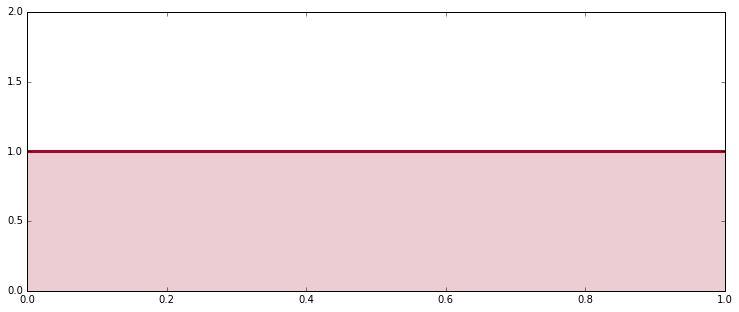

In [17]:
figsize(12.5, 5)

x = np.linspace(0.000 ,1, 150)
y = np.linspace(1.0, 1.0, 150)
lines = plt.plot(x, y, color="#A60628", lw = 3)
plt.fill_between(x, 0, y, alpha = 0.2, color = lines[0].get_color())
plt.autoscale(tight=True)
plt.ylim(0, 2);

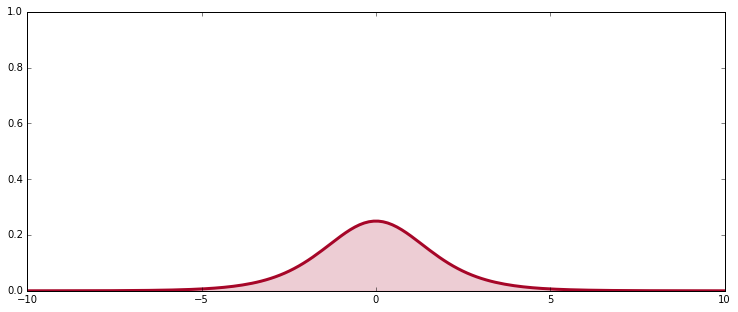

In [18]:
figsize(12.5, 5)

psi = np.linspace(-10 ,10, 150)
y = np.exp(psi) / (1 + np.exp(psi))**2
lines = plt.plot(psi, y, color="#A60628", lw = 3)
plt.fill_between(psi, 0, y, alpha = 0.2, color = lines[0].get_color())
plt.autoscale(tight=True)
plt.ylim(0, 1);

我们的函数不再flat。这说明flat先验确实携带者信息。Jeffreys Priors的观点就是创建一个当你转换在原来位置放置的变量时，不会意外地变得信息丰富的先验。

Jeffreys Priors可以定义为：

$$p_J(\theta) \propto \mathbf{I}(\theta)^\frac{1}{2}$$
$$\mathbf{I}(\theta) = - \mathbb{E}\bigg[\frac{d^2 \text{ log } p(X|\theta)}{d\theta^2}\bigg]$$

$\mathbf{I}$ being the *Fisher information*

## Effect of the prior as $N$ increases

在第一章，我提出，随着我们观察量的增加，先验分布产生的影响将会减小。这是直观的，毕竟，我们的先验信息是基于以前的信息，最终，足够的新信息将掩盖我们以前的信息价值。通过足够的数据，对不好的先验分布也是有帮助的：如果我们的先验分布是显着错误的，那么数据的自我纠正性质将会给我们一个*较少的错误*，最终是*正确*的后验。

我们可以从数学上看出这点。首先，从第一章回忆贝叶斯定理：先验和后验分布的相关性。下面是一个简单的例子，来自于[What is the relationship between sample size and the influence of prior on posterior?](http://stats.stackexchange.com/questions/30387/what-is-the-relationship-between-sample-size-and-the-influence-of-prior-on-poste)[1] on CrossValidated.

>The posterior distribution for a parameter $\theta$, given a data set ${\textbf X}$ can be written as 

$$p(\theta | {\textbf X}) \propto \underbrace{p({\textbf X} | \theta)}_{{\textrm likelihood}}  \cdot  \overbrace{ p(\theta) }^{ {\textrm prior} }  $$



>or, as is more commonly displayed on the log scale, 

$$ \log( p(\theta | {\textbf X})  ) = c + L(\theta;{\textbf X}) + \log(p(\theta)) $$

>The log-likelihood, $L(\theta;{\textbf X}) = \log \left( p({\textbf X}|\theta) \right)$, **scales with the sample size**, since it is a function of the data, while the prior density does not. Therefore, as the sample size increases, the absolute value of $L(\theta;{\textbf X})$ is getting larger while $\log(p(\theta))$ stays fixed (for a fixed value of $\theta$), thus the sum $L(\theta;{\textbf X}) + \log(p(\theta))$ becomes more heavily influenced by $L(\theta;{\textbf X})$ as the sample size increases. 

这里有一个有趣的结果没有立即显现。随着样本量的增加，所选择的先验分布影响越来越小。因此，只要概率非0的区域是一样的，那么无论选择什么先验，最终贝叶斯推断都会收敛。

下面我们可视化这个。我们检查Binomial分布的参数$\theta$的两个后验分布的收敛情况，一个具有平坦的先验，另一个具有偏向0的先验。随着样本大小的增加，因为不断的推断，后验分布会收敛。

In [ ]:
figsize(12.5, 15)

p = 0.6
beta1_params = np.array([1.,1.])
beta2_params = np.array([2,10])
beta = stats.beta

x = np.linspace(0.00, 1, 125)
data = stats.bernoulli.rvs(p, size=500)

plt.figure()
for i,N in enumerate([0,4,8, 32,64, 128, 500]):
    s = data[:N].sum() 
    plt.subplot(8,1,i+1)
    params1 = beta1_params + np.array([s, N-s])
    params2 = beta2_params + np.array([s, N-s])
    y1,y2 = beta.pdf(x, *params1), beta.pdf( x, *params2)
    plt.plot(x,y1, label = r"flat prior", lw =3)
    plt.plot(x, y2, label = "biased prior", lw= 3)
    plt.fill_between(x, 0, y1, color ="#348ABD", alpha = 0.15) 
    plt.fill_between(x, 0, y2, color ="#A60628", alpha = 0.15) 
    plt.legend(title = "N=%d" % N)
    plt.vlines(p, 0.0, 7.5, linestyles = "--", linewidth=1)
    #plt.ylim( 0, 10)#

记住，不是所有的后验都会快速“忘记”其先验分布。这个例子只是展示*最终*先验分布被遗忘了。先验分布的“健忘”是伴随着我们充斥着越来越多的数据，这就是为什么贝叶斯派和频率派推断最终收敛的原因。

### Bayesian perspective of Penalized Linear Regressions

There is a very interesting relationship between a penalized least-squares regression and Bayesian priors. A penalized linear regression is a optimization problem of the form:

$$ \text{argmin}_{\beta} \;\; (Y - X\beta)^T(Y - X\beta)  + f(\beta)$$

for some function $f$ (typically a norm like $|| \cdot ||_p^p$). 

We will first describe the probabilistic interpretation of least-squares linear regression. Denote our response variable $Y$, and features are contained in the data matrix $X$. The standard linear model is:

\begin{equation}
Y = X\beta + \epsilon
\end{equation}

where $\epsilon \sim \text{Normal}( {\textbf 0}, \sigma{\textbf I })$. Simply, the observed $Y$ is a linear function of $X$ (with coefficients $\beta$) plus some noise term. Our unknown to be determined is $\beta$. We use the following property of Normal random variables:

$$ \mu' + \text{Normal}( \mu, \sigma ) \sim \text{Normal}( \mu' + \mu , \sigma ) $$

to rewrite the above linear model as:

\begin{align}
& Y = X\beta + \text{Normal}( {\textbf 0}, \sigma{\textbf I }) \\\\
& Y = \text{Normal}( X\beta , \sigma{\textbf I }) \\\\
\end{align}

In probabilistic notation, denote $f_Y(y \; | \; \beta )$ the probability distribution of $Y$, and recalling the density function for a Normal random variable (see [here](http://en.wikipedia.org/wiki/Normal_distribution) ):

$$ f_Y( Y \; |\; \beta, X) = L(\beta|\; X,Y)= \frac{1}{\sqrt{ 2\pi\sigma} } \exp \left( \frac{1}{2\sigma^2} (Y - X\beta)^T(Y - X\beta) \right) $$

This is the likelihood function for $\beta$. Taking the $\log$:

$$ \ell(\beta) = K - c(Y - X\beta)^T(Y - X\beta) $$

where $K$ and $c>0$ are constants. Maximum likelihood techniques wish to maximize this for $\beta$, 

$$\hat{ \beta } = \text{argmax}_{\beta} \;\; - (Y - X\beta)^T(Y - X\beta) $$

Equivalently we can *minimize the negative* of the above:

$$\hat{ \beta } = \text{argmin}_{\beta} \;\; (Y - X\beta)^T(Y - X\beta) $$

This is the familiar least-squares linear regression equation. Therefore we showed that the solution to a linear least-squares is the same as the maximum likelihood assuming Normal noise. Next we extend this to show how we can arrive at penalized linear regression by a suitable choice of prior on $\beta$. 

#### Penalized least-squares

In the above, once we have the likelihood, we can include a prior distribution on $\beta$ to derive to the equation for the posterior distribution:

$$P( \beta | Y, X ) = L(\beta|\;X,Y)p( \beta )$$

where $p(\beta)$ is a prior on the elements of $\beta$. What are some interesting priors? 

1\. If we include *no explicit* prior term, we are actually including an uninformative prior, $P( \beta ) \propto 1$, think of it as uniform over all numbers. 

2\. If we have reason to believe the elements of $\beta$ are not too large, we can suppose that *a priori*:

$$ \beta \sim \text{Normal}({\textbf 0 }, \lambda {\textbf I } ) $$

The resulting posterior density function for $\beta$ is *proportional to*:

$$ \exp \left( \frac{1}{2\sigma^2} (Y - X\beta)^T(Y - X\beta) \right) \exp \left( \frac{1}{2\lambda^2} \beta^T\beta \right) $$

and taking the $\log$ of this, and combining and redefining constants, we arrive at:

$$ \ell(\beta) \propto K -  (Y - X\beta)^T(Y - X\beta) - \alpha \beta^T\beta  $$

we arrive at the function we wish to maximize (recall the point that maximizes the posterior distribution is the MAP, or *maximum a posterior*):

$$\hat{ \beta } = \text{argmax}_{\beta} \;\; -(Y - X\beta)^T(Y - X\beta) - \alpha \;\beta^T\beta $$

Equivalently, we can minimize the negative of the above, and rewriting $\beta^T \beta = ||\beta||_2^2$:

$$\hat{ \beta } = \text{argmin}_{\beta} \;\; (Y - X\beta)^T(Y - X\beta) + \alpha \;||\beta||_2^2$$

This above term is exactly Ridge Regression. Thus we can see that ridge regression corresponds to the MAP of a linear model with Normal errors and a Normal prior on $\beta$.

3\. Similarly, if we assume a *Laplace* prior on $\beta$, ie. 

$$ f_\beta( \beta) \propto \exp \left(- \lambda ||\beta||_1 \right)$$

and following the same steps as above, we recover:

$$\hat{ \beta } = \text{argmin}_{\beta} \;\; (Y - X\beta)^T(Y - X\beta) + \alpha \;||\beta||_1$$

which is LASSO regression. Some important notes about this equivalence. The sparsity that is a result of using a LASSO regularization is not a result of the prior assigning high probability to sparsity. Quite the opposite actually. It is the combination of the $|| \cdot ||_1$ function and using the MAP that creates sparsity on $\beta$: [purely a geometric argument](http://camdp.com/blogs/least-squares-regression-l1-penalty). The prior does contribute to an overall shrinking of the coefficients towards 0 though. An interesting discussion of this can be found in [2].

For an example of Bayesian linear regression, see Chapter 4's example on financial losses.

##### References

1. Macro, . "What is the relationship between sample size and the influence of prior on posterior?." 13 Jun 2013. StackOverflow, Online Posting to Cross-Validated. Web. 25 Apr. 2013.

2. Starck, J.-L., , et al. "Sparsity and the Bayesian Perspective." Astronomy & Astrophysics. (2013): n. page. Print.

3. Kuleshov, Volodymyr, and Doina Precup. "Algorithms for the multi-armed bandit problem." Journal of Machine Learning Research. (2000): 1-49. Print.

4. Gelman, Andrew. "Prior distributions for variance parameters in hierarchical models." Bayesian Analysis. 1.3 (2006): 515-533. Print.

5. Gelman, Andrew, and Cosma R. Shalizi. "Philosophy and the practice of Bayesian statistics." British Journal of Mathematical and Statistical Psychology. (2012): n. page. Web. 17 Apr. 2013.

6. http://jmlr.csail.mit.edu/proceedings/papers/v22/kaufmann12/kaufmann12.pdf

7. James, Neufeld. "Reddit's "best" comment scoring algorithm as a multi-armed bandit task." Simple ML Hacks. Blogger, 09 Apr 2013. Web. 25 Apr. 2013.

8. Oakley, J. E., Daneshkhah, A. and O’Hagan, A. Nonparametric elicitation using the roulette method. Submitted to Bayesian Analysis.

9. "Eliciting priors from experts." 19 Jul 2010. StackOverflow, Online Posting to Cross-Validated. Web. 1 May. 2013. <http://stats.stackexchange.com/questions/1/eliciting-priors-from-experts>.

10. Taleb, Nassim Nicholas (2007), The Black Swan: The Impact of the Highly Improbable, Random House, ISBN 978-1400063512

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()